In [1]:
import numpy as np
from scipy.stats import t
import scipy.io
from bisect import bisect
from scipy.stats import norm
import matplotlib.pylab as plt
%pylab inline

mat = scipy.io.loadmat('minist7vs1.mat')
print mat
TrainLabel = mat['TrainLabel']
TrainImg = mat['TrainImg']
TestImg = mat['TestImg']
TestLabel = mat['TestLabel']

Populating the interactive namespace from numpy and matplotlib
{'TrainLabel': array([[-1., -1.,  1., ...,  1.,  1., -1.]]), 'TrainImg': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), '__header__': 'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri May 13 17:33:30 2016', 'TestImg': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), '__globals__': [], '__version__': '1.0', 'TestLabel': array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
    

`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# we have Training data as:
# TrainLabel, and TrainImg, their shape is
print TrainLabel.shape, TrainImg.shape
# the TrainImg is n * p, p is num of the features, n is number of instance

# we have Testing data as:
# TestImg TestLabel
print TestImg.shape, TestLabel.shape


(1, 12007) (12007, 784)
(1000, 784) (1, 1000)


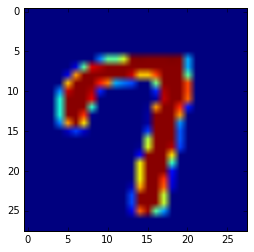

label is (1 is 1, -1 is 7):  -1.0


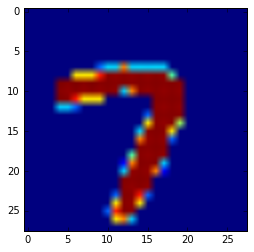

label is (1 is 1, -1 is 7):  -1.0


In [3]:
# randomly check the data
index = np.random.choice(12007)
plt.imshow(TrainImg[index,:].reshape(28, 28))
plt.show()
print 'label is (1 is 1, -1 is 7): ', TrainLabel[0, index]
index = np.random.choice(1000)
plt.imshow(TestImg[index,:].reshape(28, 28))
plt.show()
print 'label is (1 is 1, -1 is 7): ', TestLabel[0, index]

In [42]:
# model class
# assume binary classes, 1 or -1
class Logistic:
    def __init__(self, num_featurs, proposer = None):
        # init the feature vector
        self.p = num_featurs
        self.proposer = proposer
    
    def ll(self, feature, X, Y):
        # return the log likelihood
        res = 0.0
        [n, p] = X.shape
        n1 = Y.shape[0]
        assert p == self.p
        assert n1 == n
        for i in range(n):
            res += np.log(1.0 + np.exp(-1.0 * Y[i] * np.sum(feature * X[i,:])))
        res = res * (-1.0)
        return res / n
    
    def delta(self, f_old, f_new, X, Y):
        res = self.ll(f_new, X, Y) - self.ll(f_old, X, Y)
        res += self.proposer.probGenerate(f_new, f_old, X, Y) # new -> old
        res = res - self.proposer.probGenerate(f_old, f_new, X, Y)  # old -> new
        return res
    
    def grad(self, feature, X, Y):
        # compute the grad of the ll
        [n, p] = X.shape
        n1 = Y.shape[0]
        res = np.zeros(self.p)
        assert p == self.p
        assert n1 == n
        for i in range(n):
            res += Y[i] * X[i,:] / (1 + np.exp(Y[i] * np.sum(feature * X[i,:])))
        return res/ n
    def predAcc(self, f, X, Y):
        [n, p] = X.shape
        n1 = Y.shape[0]
        assert p == self.p
        assert n1 == n
        N_correct = 0
        for i in range(n):
            p = 1.0 / (1 + np.exp(-1.0 * np.sum(f * X[i,:])))
            if p > 0.5 and Y[i] == 1.0:
                N_correct += 1.0
            elif p < 0.5 and Y[i] == -1.0:
                N_correct += 1.0
        return N_correct / n
    def pred(self, f, X):
        a = X.shape
        if len(a) == 1:
            p = 1.0 / (1 + np.exp(-1.0 * np.sum(f * X)))
            if p > 0.5:
                return 1.0
            else:
                return -1.0
        else:
            [n, p] = X.shape
        res = np.zeros(n)
        for i in range(n):
            p = 1.0 / (1 + np.exp(-1.0 * np.sum(f * X[i,:])))
            if p > 0.5:
                res[i] = 1.0
            else:
                res[i] = -1.0
        return res

In [6]:
def randomPropose(beta, sig):
    p = len(beta)
    res = np.zeros(p)
    res = beta + np.random.normal(0,sig, p)
    return res

def randomData(miniBatchSize, im, label):
    n = label.shape[1]
    id = np.random.choice(n, miniBatchSize)
    img = im[id,:]
    idx = label[0,id]
    return (img, idx)
mat = scipy.io.loadmat('ecdf.mat')
x_l = mat['x_l'][0]
x_corr = mat['x_corr'][0]
ecdf_l = mat['ecdf_l'][0]
ecdf_corr = mat['ecdf_corr'][0]

In [7]:
# test by gradient descent
alpha = 0.7
p = 784
v = np.zeros(p)
beta = np.random.rand(p)
N = 1000
ll = []
acc = []
e0 = 0.1
logmodel = Logistic(p)
batchSize = 20
for i in range(N):
    # get the data
    data = randomData(batchSize, TrainImg, TrainLabel)
    step = 1.0* e0 / (i+1.0)**0.5
    v = v*alpha + step * logmodel.grad(beta, data[0], data[1])
    beta = beta + v
    if i % 10 == 0:
        data = randomData(200, TestImg, TestLabel)
        ll.append(logmodel.ll(beta, data[0], data[1]))
        acc.append(logmodel.predAcc(beta, data[0], data[1]))

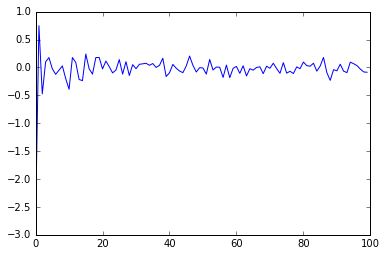

In [8]:
plt.plot(ll)

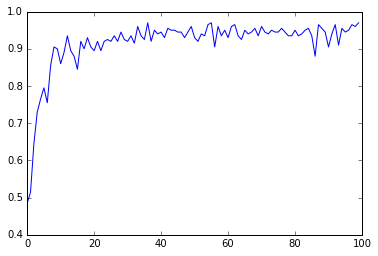

In [9]:
plt.plot(acc)

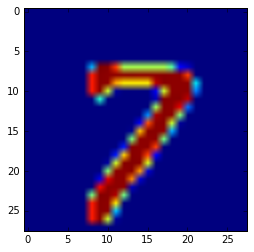

pred:  -1.0 truth:  -1.0


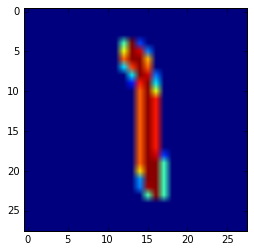

pred:  1.0 truth:  1.0


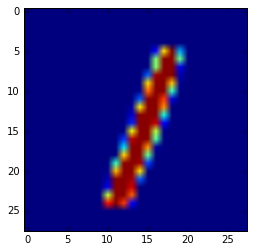

pred:  1.0 truth:  1.0


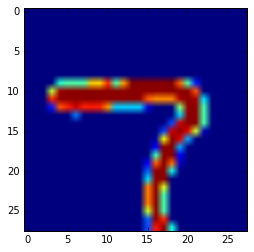

pred:  -1.0 truth:  -1.0


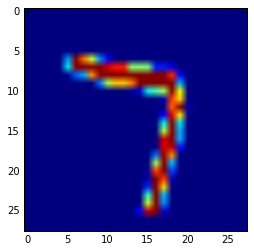

pred:  -1.0 truth:  -1.0


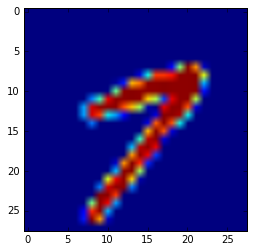

pred:  -1.0 truth:  -1.0


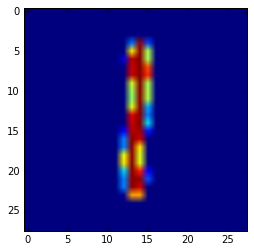

pred:  1.0 truth:  1.0


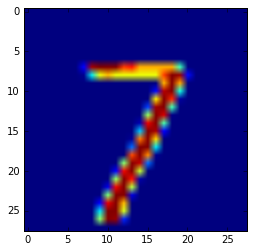

pred:  -1.0 truth:  -1.0


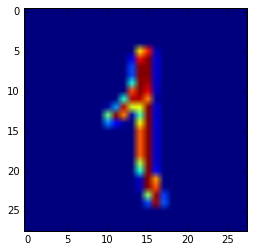

pred:  1.0 truth:  1.0


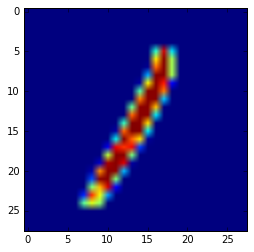

pred:  1.0 truth:  1.0


In [18]:
# test randomly
for i in range(10):
    id = np.random.choice(1000)
    img = TestImg[id,:]
    idx = TestLabel[0,id]
    plt.imshow(img.reshape(28,28))
    plt.show()
    lg = Logistic(p)
    # print img.shape
    print 'pred: ', lg.pred(beta, img), 'truth: ', idx


In [14]:
def randomPropose(beta, sig):
    p = len(beta)
    res = np.zeros(p)
    res = beta + np.random.normal(0,sig, p)
    return res

def randomData(miniBatchSize, im, label):
    n = label.shape[1]
    id = np.random.choice(n, miniBatchSize)
    img = im[id,:]
    idx = label[0,id]
    return (img, idx)
mat = scipy.io.loadmat('ecdf.mat')
x_l = mat['x_l'][0]
x_corr = mat['x_corr'][0]
ecdf_l = mat['ecdf_l'][0]
ecdf_corr = mat['ecdf_corr'][0]

In [19]:
class LangvanProposer:
    def __init__(self, model):
        self.m = model
        self.step = 1.0
    def setStepSize(self, s):
        self.step = s
        
    def update(self, beta, X, Y):
        beta1 = beta + self.step / 2.0 * self.m.grad(beta, X, Y)
        # add the noise
        p = len(beta1)
        beta1 = beta1 + np.random.normal(0, self.step**0.5, p)
        return beta1
    
    def probGenerate(self, beta_old, beta_new, X, Y):
        # beta_old -> beta_new
        beta_tmp = beta_old + self.step / 2.0 * self.m.grad(beta_old, X, Y)
        # find the diff
        diff = beta_tmp - beta_new
        res = -1.0 * np.sum(diff**2.0) / 2.0 / self.step
        return res
        
class RandomWalkProposer:
    def update(self, beta, sig):
        p = len(beta)
        res = np.zeros(p)
        res = beta + np.random.normal(0,sig, p)
        return res
    def probGenerate(self, beta_old, beta_new, X, Y):
        return 1.0

class NoiseGradDescentProposer:
    def __init__(self, model, sd):
        self.m = model
        self.sd = sd
        self.step = 1.0
    def setStepSize(self, s):
        self.step = s
        
    def update(self, beta, X, Y):
        beta1 = beta + self.step / 2.0 * self.m.grad(beta, X, Y)
        # add the noise
        p = len(beta1)
        beta1 = beta1 + np.random.normal(0, self.sd, p)
        return beta1
    
    def probGenerate(self, beta_old, beta_new, X, Y):
        # beta_old -> beta_new
        beta_tmp = beta_old + self.step / 2.0 * self.m.grad(beta_old, X, Y)
        # find the diff
        diff = beta_tmp - beta_new
        res = -1.0 * np.sum(diff**2.0) / 2.0 / self.sd**2
        return res

In [ ]:
# test for Lp
p = 784
beta = np.random.rand(p)
sig = 0.1
logm = Logistic(p)
data = randomData(20, TrainImg, TrainLabel)
lp = LangvanProposer(logm)
beta1 = lp.update(beta, data[0], data[1])
pg = lp.probGenerate(beta, beta1, data[0], data[1])
print pg
model = Logistic(p, lp)
print model.delta(beta, beta1, data[0], data[1])

In [96]:
# try the mini_batch
N = 1000
p = 784
#beta = np.random.rand(p)
beta = np.ones(p)
rd = RandomWalkProposer()
sig0 = 0.1
logm = Logistic(p, rd)
sd_est = 0
sd_array = np.zeros(N)
miniBatchSize = 2
num_sd = 10
ll = []
acc = []
ll_full = np.zeros(N)
acc_full = np.zeros(N)
for i in range(N):
    sd_vect = np.zeros(num_sd)
    # sig = sig0 / (i + 1.0)**0.5
    sig = sig0
    for j in range(num_sd):
        data = randomData(miniBatchSize, TrainImg, TrainLabel)
        beta1 = rd.update(beta, sig)
        sd_vect[j] = logm.delta(beta, beta1, data[0], data[1])
    sd_est = sd_est *0.7 + np.std(sd_vect) *0.3
    u = np.random.random()
    sd_array[i] = sd_est
    # X_log = ecdf_l[bisect(x_l, u)]
    x_c = x_corr[bisect(ecdf_corr, u)]
    x_c = x_c *sd_est
    beta1 = rd.update(beta, sig)
    data = randomData(miniBatchSize, TrainImg, TrainLabel)
    delta = logm.delta(beta, beta1, data[0], data[1])
    if (delta + x_c > 0):
        beta = beta1
    data = randomData(200, TestImg, TestLabel)
    ll.append(logm.ll(beta, data[0], data[1]))
    acc.append(logm.predAcc(beta, data[0], data[1]))
    ll_full[i] = logm.ll(beta, TestImg[0:1000,:], TestLabel[0,0:1000])
    acc_full[i] = logm.predAcc(beta, TestImg[0:1000,:], TestLabel[0,0:1000])

In [97]:
# cumulative sum of the x-axis
data_x = np.ones(N)
data_x *= 2
data_x = cumsum(data_x)

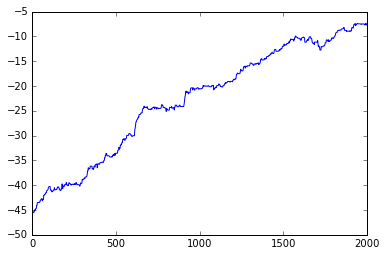

In [98]:
plt.plot(data_x, ll_full)


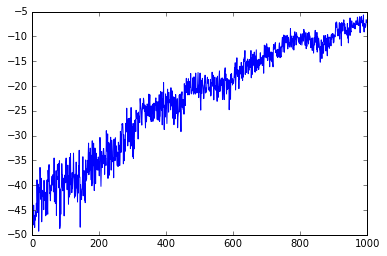

In [101]:
plt.plot(ll)

In [117]:
# do the sampling for the roofline
evalSize = 1000
N = 2000
p = 784
#beta = np.random.rand(p)
beta = np.ones(p)
rd = RandomWalkProposer()
sig0 = 0.1
logm = Logistic(p, rd)
sd_est = 0
sd_array = np.zeros(N)
miniBatchSize = 2
num_sd = 10
ll = []
acc = []
mini_batchArray = [i*2 + 1 for i in range(20)]
print mini_batchArray

#mini_batchArray = [1, 2, 3, 4, 5, 6, 7, 8,9, 10,11,12, 13, 14, 15, 20]
ll_full =[]
acc_full = []

for miniBatchSize in mini_batchArray:
    cumdata = 0
    beta = np.ones(p)
    for i in range(N):
        cumdata += miniBatchSize
        sd_vect = np.zeros(num_sd)
        # sig = sig0 / (i + 1.0)**0.5
        sig = sig0
        for j in range(num_sd):
            data = randomData(miniBatchSize, TrainImg, TrainLabel)
            beta1 = rd.update(beta, sig)
            sd_vect[j] = logm.delta(beta, beta1, data[0], data[1])
        sd_est = sd_est *0.7 + np.std(sd_vect) *0.3
        u = np.random.random()
        sd_array[i] = sd_est
        # X_log = ecdf_l[bisect(x_l, u)]
        x_c = x_corr[bisect(ecdf_corr, u)]
        x_c = x_c *sd_est
        beta1 = rd.update(beta, sig)
        data = randomData(miniBatchSize, TrainImg, TrainLabel)
        delta = logm.delta(beta, beta1, data[0], data[1])
        if (delta + x_c > 0):
            beta = beta1
        if (i >= evalSize):
            #data = randomData(200, TestImg, TestLabel)
            #ll.append(logm.ll(beta, data[0], data[1]))
            #acc.append(logm.predAcc(beta, data[0], data[1]))
            ll_full.append(logm.ll(beta, TestImg[0:1000,:], TestLabel[0,0:1000]))
            acc_full.append(logm.predAcc(beta, TestImg[0:1000,:], TestLabel[0,0:1000]))
            break
        

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]


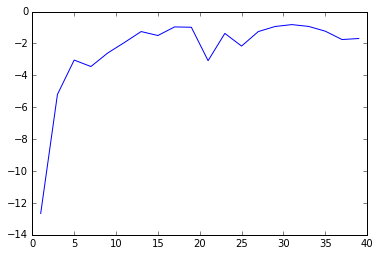

In [119]:
plt.plot(mini_batchArray, ll_full)

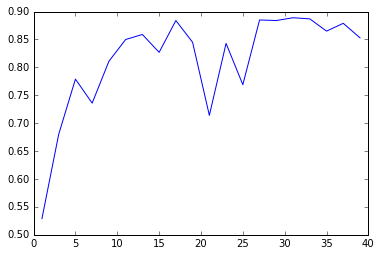

In [120]:
plt.plot(mini_batchArray, acc_full)

In [43]:
# try the mini_batch
N = 1000
p = 784
beta = np.random.rand(p)
rd = RandomWalkProposer()
sig0 = 0.1
logm = Logistic(p, rd)
sd_est = 0
sd_array = np.zeros(N)
miniBatchSize = 2000
num_sd = 10
ll = []
acc = []

for i in range(N):
    sd_vect = np.zeros(num_sd)
    # sig = sig0 / (i + 1.0)**0.5
    sig = sig0
    # for j in range(num_sd):
    #    data = randomData(miniBatchSize, TrainImg, TrainLabel)
    #    beta1 = rd.update(beta, sig)
    #    sd_vect[j] = logm.delta(beta, beta1, data[0], data[1])
    # sd_est = sd_est *0.7 + np.std(sd_vect) *0.3
    u = np.random.random()
    # sd_array[i] = sd_est
    # X_log = ecdf_l[bisect(x_l, u)]
    # x_c = x_corr[bisect(ecdf_corr, u)]
    # x_c = x_c *sd_est
    beta1 = rd.update(beta, sig)
    data = randomData(miniBatchSize, TrainImg, TrainLabel)
    delta = logm.delta(beta, beta1, data[0], data[1])
    Pa = np.min([1.0, np.exp(delta)])
    print Pa
    # delta = logm.delta(beta, beta1, data[0], data[1])
    if (u < Pa):
        beta = beta1
        # data = randomData(100, TestImg, TestLabel)
        ll.append(logm.ll(beta, data[0], data[1]))
        acc.append(logm.predAcc(beta, data[0], data[1]))

1.0
0.947787579862
1.0
0.63337870866
0.955300948223
1.0
1.0
1.0
0.811286566295
1.0
1.0
0.761722819828
0.646425773112
0.902476083395
0.7954856935
0.71378829323
1.0
1.0
1.0
1.0
0.847843105185
1.0
1.0
1.0
1.0
0.709593150251
1.0
1.0
1.0
1.0
1.0
0.900186775057
1.0
0.742810993316
1.0
1.0
0.639402775187
0.997718343838
0.918568687179
0.944962152158
0.825360225169
1.0
1.0
0.719148898178
1.0
1.0
0.747425167394
1.0
0.744177478416
1.0
0.7349431922
1.0
0.620234391991
1.0
0.773781765879
1.0
1.0
0.67706122144
0.612285668376
0.871939159248
1.0
0.828797492782
0.858004171146
0.703541661898
1.0
1.0
0.916891580607
1.0
1.0
0.946866499442
1.0
1.0
0.78879543149
0.520659518207
0.923965337322
1.0
1.0
0.717910665788
1.0
1.0
1.0
1.0
0.836340772802
0.679352772595
1.0
0.715627003037
1.0
1.0
0.832919943613
0.953772405738
0.614214268514
0.972587413979
0.815985614572
1.0
1.0
1.0
0.847537456749
1.0
0.780230470852
1.0
1.0
0.797010981249
1.0
0.678097244594
1.0
0.785009860173
1.0
0.896662685777
1.0
0.766602839476
0.96849

In [39]:
np.min([3,0])

0

In [94]:
# try the mini_batch
N = 2000
p = 784
# beta = np.random.rand(p)
beta = np.zeros(p)
sig = 0.1
model = Logistic(p)
lp = NoiseGradDescentProposer(model, 0.1)
logm = Logistic(p, lp)
miniBatchSize = 20
num_sd = 10
sd = 0
ll = []
acc = []
s0 = 0.1
sd_est = np.zeros(N)
llfull = []
accfull = []

for i in range(N):
    sd_vect = np.zeros(num_sd)
    step = s0 / (i+1.0)**0.5
    # step = s0
    lp.setStepSize(step)
    for j in range(num_sd):
        data = randomData(miniBatchSize, TrainImg, TrainLabel)
        beta1 = lp.update(beta, data[0], data[1])
        sd_vect[j] = logm.delta(beta, beta1, data[0], data[1])
    # print sd_vect
    sd = sd *0.7 + np.std(sd_vect) *0.3
    sd_est[i] = sd
    # print sd
    u = np.random.random()
    # X_log = ecdf_l[bisect(x_l, u)]
    x_c = x_corr[bisect(ecdf_corr, u)]
    x_c = x_c *sd
    # print x_c
    data = randomData(miniBatchSize, TrainImg, TrainLabel)
    beta1 = lp.update(beta, data[0], data[1])
    delta = logm.delta(beta, beta1, data[0], data[1])
    # print delta
    if (delta + x_c > 0):
        beta = beta1
        #data = randomData(100, TestImg, TestLabel)
        #ll.append(logm.ll(beta, data[0], data[1]))
        #acc.append(logm.predAcc(beta, data[0], data[1]))
    
    data = randomData(100, TestImg, TestLabel)
    llfull.append(logm.ll(beta, data[0], data[1]))
    accfull.append(logm.predAcc(beta, data[0], data[1]))

In [95]:
# try simple sgd
N = 2000
p = 784
# beta = np.random.rand(p)
beta = np.zeros(p)
sig = 0.1
model = Logistic(p)
lp = NoiseGradDescentProposer(model, 0.1)
logm = Logistic(p, lp)
miniBatchSize = 20

ll2 = []
acc2 = []
s0 = 0.1


for i in range(N):
    sd_vect = np.zeros(num_sd)
    step = s0 / (i+1.0)**0.5
    # step = s0
    lp.setStepSize(step)
    
    u = np.random.random()
    # X_log = ecdf_l[bisect(x_l, u)]
    
    data = randomData(miniBatchSize, TrainImg, TrainLabel)
    beta1 = lp.update(beta, data[0], data[1])
    beta = beta1
    data = randomData(100, TestImg, TestLabel)
    ll2.append(logm.ll(beta, data[0], data[1]))
    acc2.append(logm.predAcc(beta, data[0], data[1]))

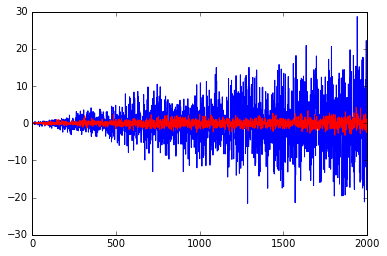

In [96]:
plt.plot(llfull)
plt.plot(ll2, 'r')
plt.show()

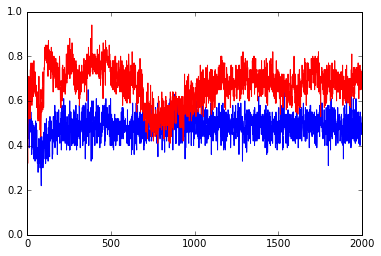

In [97]:
plt.plot(accfull)
plt.plot(acc2, 'r')
plt.show()

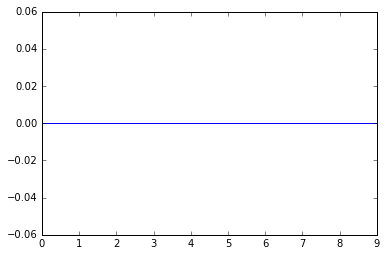

In [98]:
plt.plot(sd_vect)

In [ ]:
plt.plot(sd_est)

(array([  1.,   3.,   7.,  32.,  41.,  11.,   3.,   1.,   0.,   1.]),
 array([-5.31 , -4.012, -2.714, -1.416, -0.118,  1.18 ,  2.478,  3.776,
         5.074,  6.372,  7.67 ]),
 <a list of 10 Patch objects>)

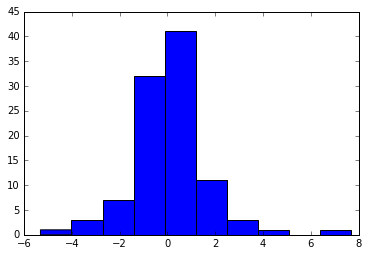

In [25]:
res = np.zeros(100)
for i in range(100):
    u = np.random.rand()
    res[i] = x_corr[bisect(ecdf_corr, u)]
plt.hist(res)